In [40]:
import numpy as np
import json
import matplotlib.pyplot as plt
from selfRotateJsonProcess import process_self_rotate_data

In [41]:
json_file_path = "state_s120.json"  # Replace with your actual file path

state_dict = process_self_rotate_data(json_file_path, omega_self_0=0.0)

L = 18.0

plt.rcParams['font.size'] = 32
plt.rcParams['axes.labelsize'] = 40
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40    

In [42]:
sorted_keys = sorted(state_dict.keys(), key=int)
n_states = len(sorted_keys)

time = np.array([state_dict[k]['time'] for k in sorted_keys])
theta = np.array([state_dict[k]['theta'] for k in sorted_keys])
omega = np.array([state_dict[k]['omega'] for k in sorted_keys])
velocity = np.array([state_dict[k]['velocity'] for k in sorted_keys])
dvdt = np.array([state_dict[k]['acc_pv'] for k in sorted_keys])
a_centi_p = omega**2 * L

# Passenger coordinate accelerations
theta_s = np.array([state_dict[k]['theta_s'] for k in sorted_keys])
acc_N_x = np.array([state_dict[k]['acc_N_x'] for k in sorted_keys])
acc_N_y = np.array([state_dict[k]['acc_N_y'] for k in sorted_keys])
acc_N_z = np.array([state_dict[k]['acc_N_z'] for k in sorted_keys])

# Additional quantities
jerk = np.array([state_dict[k]['jerk'] for k in sorted_keys])
coriolis = np.array([state_dict[k]['coriolis'] for k in sorted_keys])

L = 18.0
t1, f1 = 39.609093, 817684.72
t2, f2 = 83.234, 911223.0


stable_index = np.where((time >= t1) & (time <= t2))[0]
n_stable_index = len(stable_index)
theta_processed = theta.copy()
for i in stable_index:
    if theta[i] >= np.pi:
        for j in range(i + 1, n_stable_index):
            if theta[j] > -np.pi:
                theta_processed[j] = - np.pi
            if theta[j] == -np.pi:
                i = j
                break
        


In [43]:
def calculate_torque(time, theta, t1, f1, t2, f2):
    tau = np.zeros_like(time)
    for i in range(len(time)):
        t = time[i]
        th = np.rad2deg(theta[i])
        if -10 <= th <= 10:
            if t < t1:
                tau[i] = f1
            elif t > t2:
                tau[i] = f2
    return tau

torque = calculate_torque(time, theta, t1, f1, t2, f2)

In [44]:
def calculate_total_acceleration(acc_N_x, acc_N_y, acc_N_z):
    """
    Calculate total weighted acceleration based on perceptual weighting matrix.
    
    a_total(t) = sqrt(a^T(t) * A * a(t))
    
    where A = diag(p_x, p_y, p_z):
    - p_x = 1.0 (acc_x < 0), 1.5 (acc_x >= 0)
    - p_y = 0.71 (constant)
    - p_z = 1.95 (acc_z < 0), 3.9 (acc_z >= 0)
    """
    acc_N_x = np.asarray(acc_N_x)
    acc_N_y = np.asarray(acc_N_y)
    acc_N_z = np.asarray(acc_N_z)
    
    # Assign perceptual weights
    # p_x = np.where(acc_N_x < 0, 1.0, 1.5)
    # p_y = 0.71
    # p_z = np.where(acc_N_z < 0, 1.95, 3.9)
    p_x, p_y, p_z = 1.0, 0.71, 1.95  # Using constant weights as per latest requirement
    
    # Calculate weighted acceleration
    a_total = np.sqrt((p_x * acc_N_x)**2 + (p_y * acc_N_y)**2 + (p_z * acc_N_z)**2)
    
    return a_total

In [45]:
def dadt(acc_N_x, acc_N_y, acc_N_z, time, maxAcc=24.91):
    jerk_x = np.gradient(acc_N_x, time)
    jerk_y = np.gradient(acc_N_y, time)
    jerk_z = np.gradient(acc_N_z, time)
    num_value = np.sqrt(jerk_x**2 + jerk_y**2 + jerk_z**2)
    # IF num_value > 20 THEN CLIP TO 20
    num_value = np.clip(num_value, None, maxAcc)
    return num_value



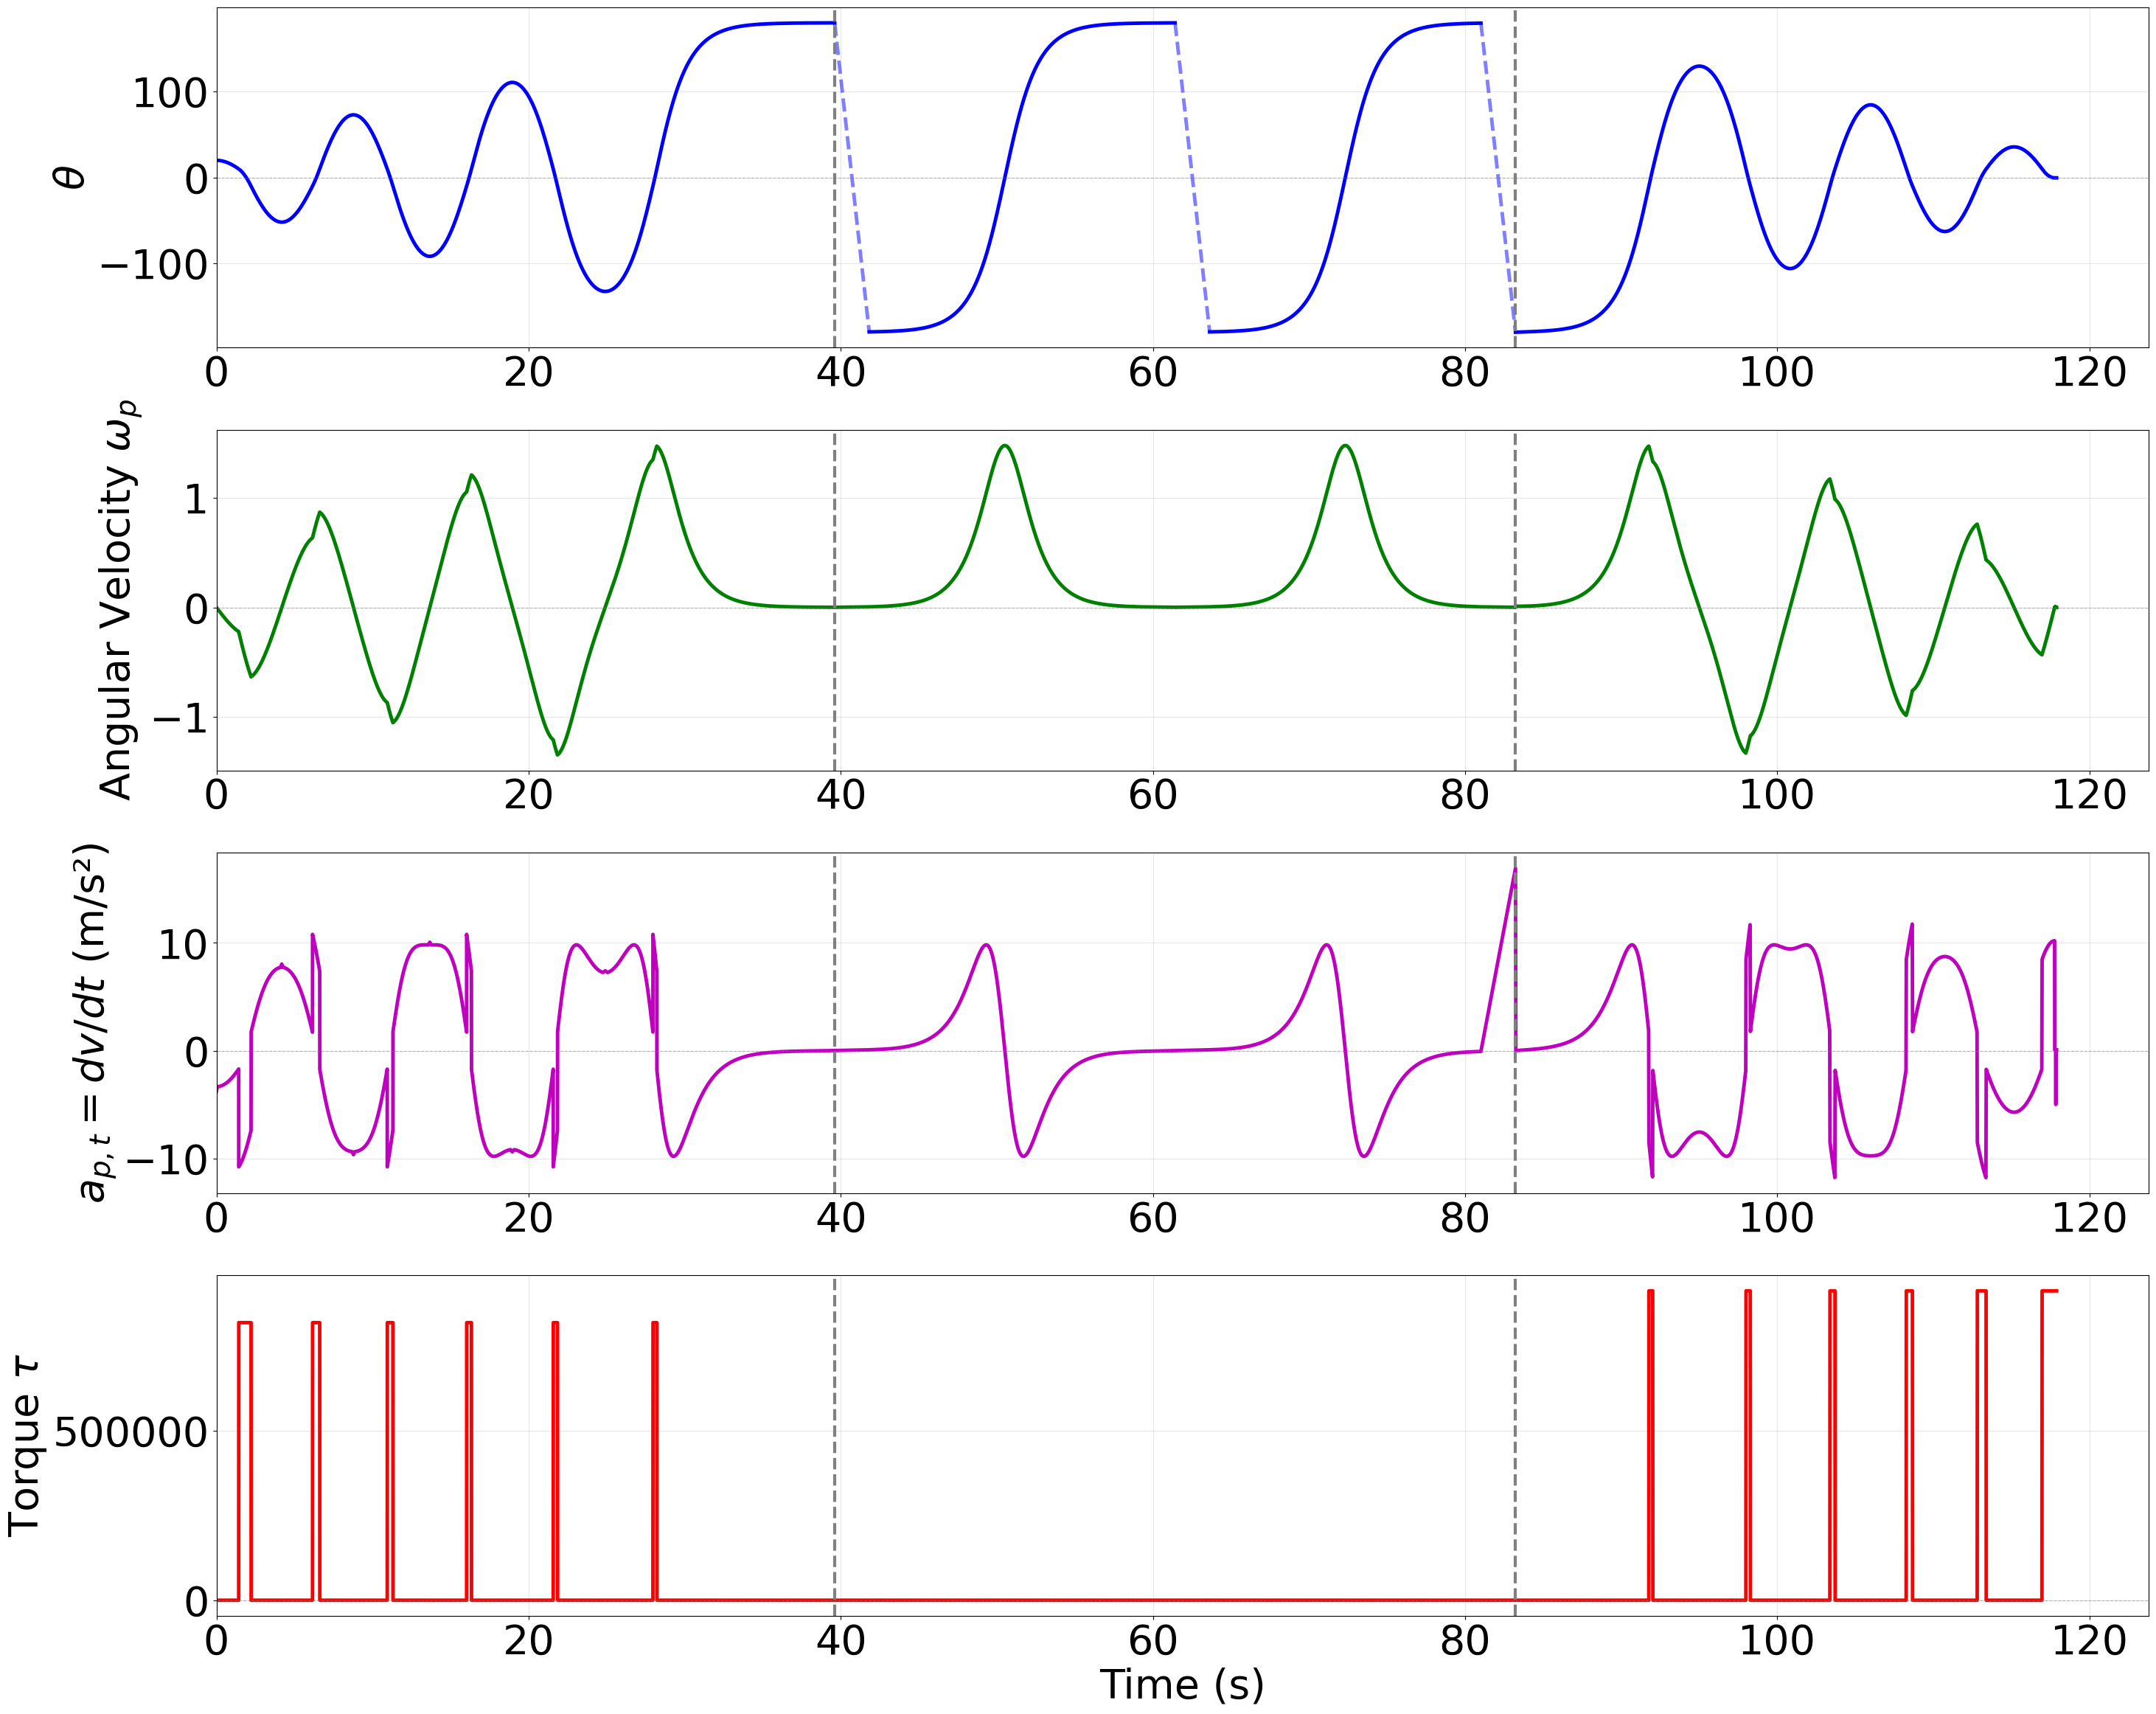

In [46]:
fig, axes = plt.subplots(4, 1, figsize=(30, 24))
# 转换为角度
theta_deg = np.rad2deg(theta_processed)

# 检测跳变点（从π到-π或从-π到π）
jump_threshold = 350  # 角度跳变阈值（接近360度）
diff = np.abs(np.diff(theta_deg))
jump_indices = np.where(diff > jump_threshold)[0]

# 分段绘制
start_idx = 0
for jump_idx in jump_indices:
    # 绘制实线段
    axes[0].plot(time[start_idx:jump_idx+1], theta_deg[start_idx:jump_idx+1], 
                 'b-', linewidth=3.5)
    
    # 绘制虚线连接跳变点
    axes[0].plot(time[jump_idx:jump_idx+2], theta_deg[jump_idx:jump_idx+2], 
                 'b--', linewidth=3.5, alpha=0.5)
    
    start_idx = jump_idx + 1

# 绘制最后一段
axes[0].plot(time[start_idx:], theta_deg[start_idx:], 'b-', linewidth=3.5)

axes[0].set_ylabel(r'$\theta$')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(time[0], None)
axes[0].axvline(t1, color='grey', linestyle='--', linewidth=3.0)
axes[0].axvline(t2, color='grey', linestyle='--', linewidth=3.0)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# Row 2: Angular velocity omega
axes[1].plot(time, omega, 'g-', linewidth=3.5)
axes[1].axvline(t1, color='grey', linestyle='--', linewidth=3.0)
axes[1].axvline(t2, color='grey', linestyle='--', linewidth=3.0)
axes[1].set_ylabel(r'Angular Velocity $\omega_p$')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(time[0], None)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# Row 3: Velocity Acceleration dv/dt
axes[2].plot(time, dvdt, 'm-', linewidth=3.5)
axes[2].axvline(t1, color='grey', linestyle='--', linewidth=3.0)
axes[2].axvline(t2, color='grey', linestyle='--', linewidth=3.0)
axes[2].set_ylabel(r'$a_{p, t} = dv/dt$ (m/s²)')
axes[2].set_xlim(time[0], None)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# Row 5: Torque τ
axes[3].plot(time, torque, 'r-', linewidth=3.5)
axes[3].set_xlim(time[0], None)
axes[3].axvline(t1, color='grey', linestyle='--', linewidth=3.0)
axes[3].axvline(t2, color='grey', linestyle='--', linewidth=3.0)
axes[3].set_ylabel(r'Torque $\tau$')
axes[3].set_xlabel('Time (s)')
axes[3].grid(True, alpha=0.3)
axes[3].axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.savefig('doc/PendulumMotion.png')
plt.show()

================== Excitement Value Statistics without SelfRotate=================
Max Excitement Value: 4.259
Min Excitement Value: 0.212
Total Excitement Value (Integral): 152.099
Average Excitement Value: 1.290
Average Total Acceleration: 31.973 m/s²
Max Total Acceleration: 81.159 m/s²
Average Scale Height: 21.648 m
Max Scale Height: 36.000 m
Average Jerk: 8.035 m/s³
Max Jerk: 24.910 m/s³


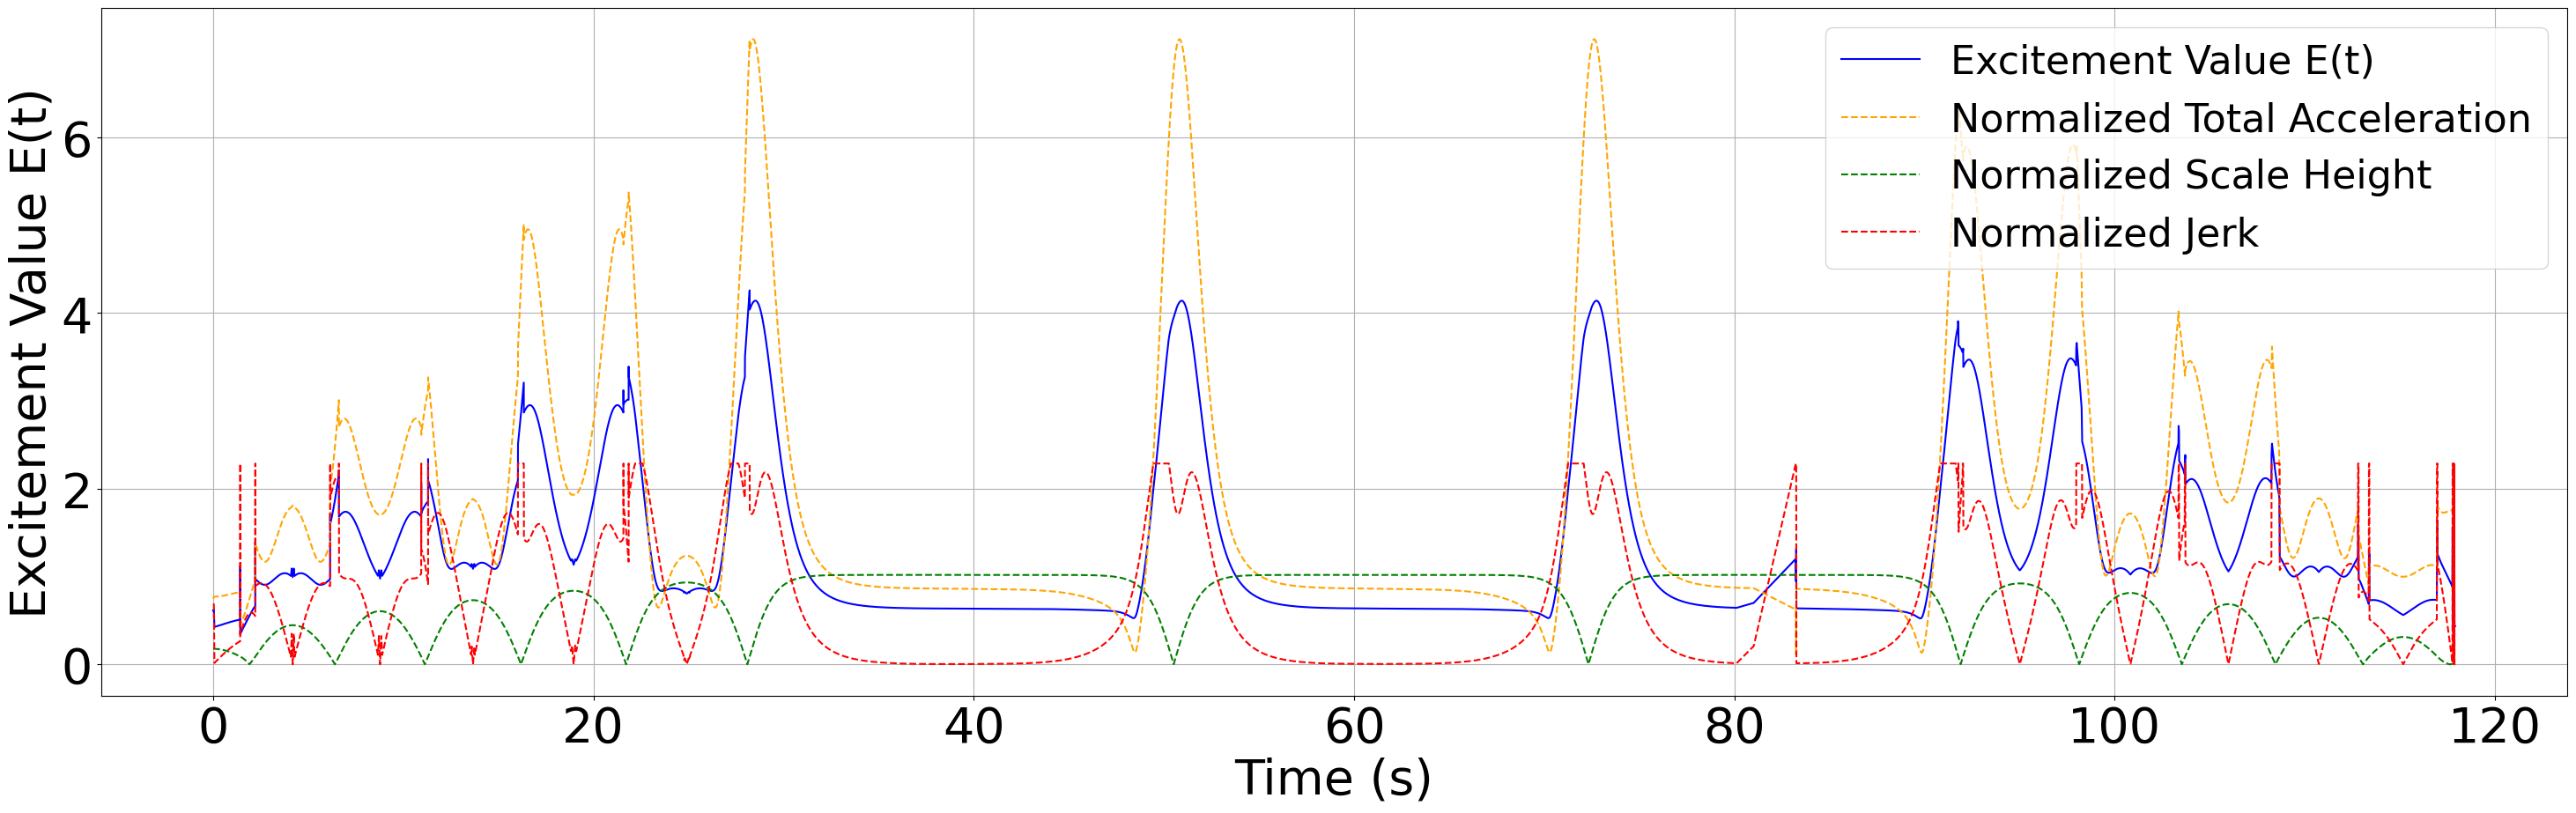

In [47]:
def excitement_value(a_total, scale_h, jerk):
    """
    Calculate excitement value E(t) = a_total(t) * scale_h(t)
    """
    ExV = 0.5 * a_total / 11.4 + 0.3 * jerk / 10.89 + 0.2 * scale_h / 5.89
    return ExV

a_total = calculate_total_acceleration(acc_N_x, acc_N_y, acc_N_z)
height = L * (1 - np.cos(theta))
scale_h = (height) ** 0.5
dadt_value = dadt(acc_N_x, acc_N_y, acc_N_z, time)
ExV = excitement_value(a_total, scale_h, dadt_value)


print("================== Excitement Value Statistics without SelfRotate=================")
min_index = np.argmin(ExV)
print(f"Max Excitement Value: {np.max(ExV):.3f}")
print(f"Min Excitement Value: {np.min(ExV):.3f}")
total_ExV = np.trapezoid(ExV, time)
print(f"Total Excitement Value (Integral): {total_ExV:.3f}")
print(f"Average Excitement Value: {total_ExV/time[-1]:.3f}")


print(f"Average Total Acceleration: {np.mean(a_total):.3f} m/s²")
print(f"Max Total Acceleration: {np.max(a_total):.3f} m/s²")
print(f"Average Scale Height: {np.trapezoid(height, time)/time[-1]:.3f} m")
print(f"Max Scale Height: {np.max(height):.3f} m")
print(f"Average Jerk: {np.trapezoid(dadt_value, time)/time[-1]:.3f} m/s³")
print(f"Max Jerk: {np.max(dadt_value):.3f} m/s³")


plt.figure(figsize=(30, 10))
plt.plot(time, ExV, label='Excitement Value E(t)', color='blue')
plt.plot(time, a_total / 11.4, label='Normalized Total Acceleration', color='orange', linestyle='--')
plt.plot(time, scale_h / 5.89, label='Normalized Scale Height', color='green', linestyle='--')
plt.plot(time, dadt_value / 10.89, label='Normalized Jerk', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Excitement Value E(t)')
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig('doc/ExF-NoR.png')
plt.show()

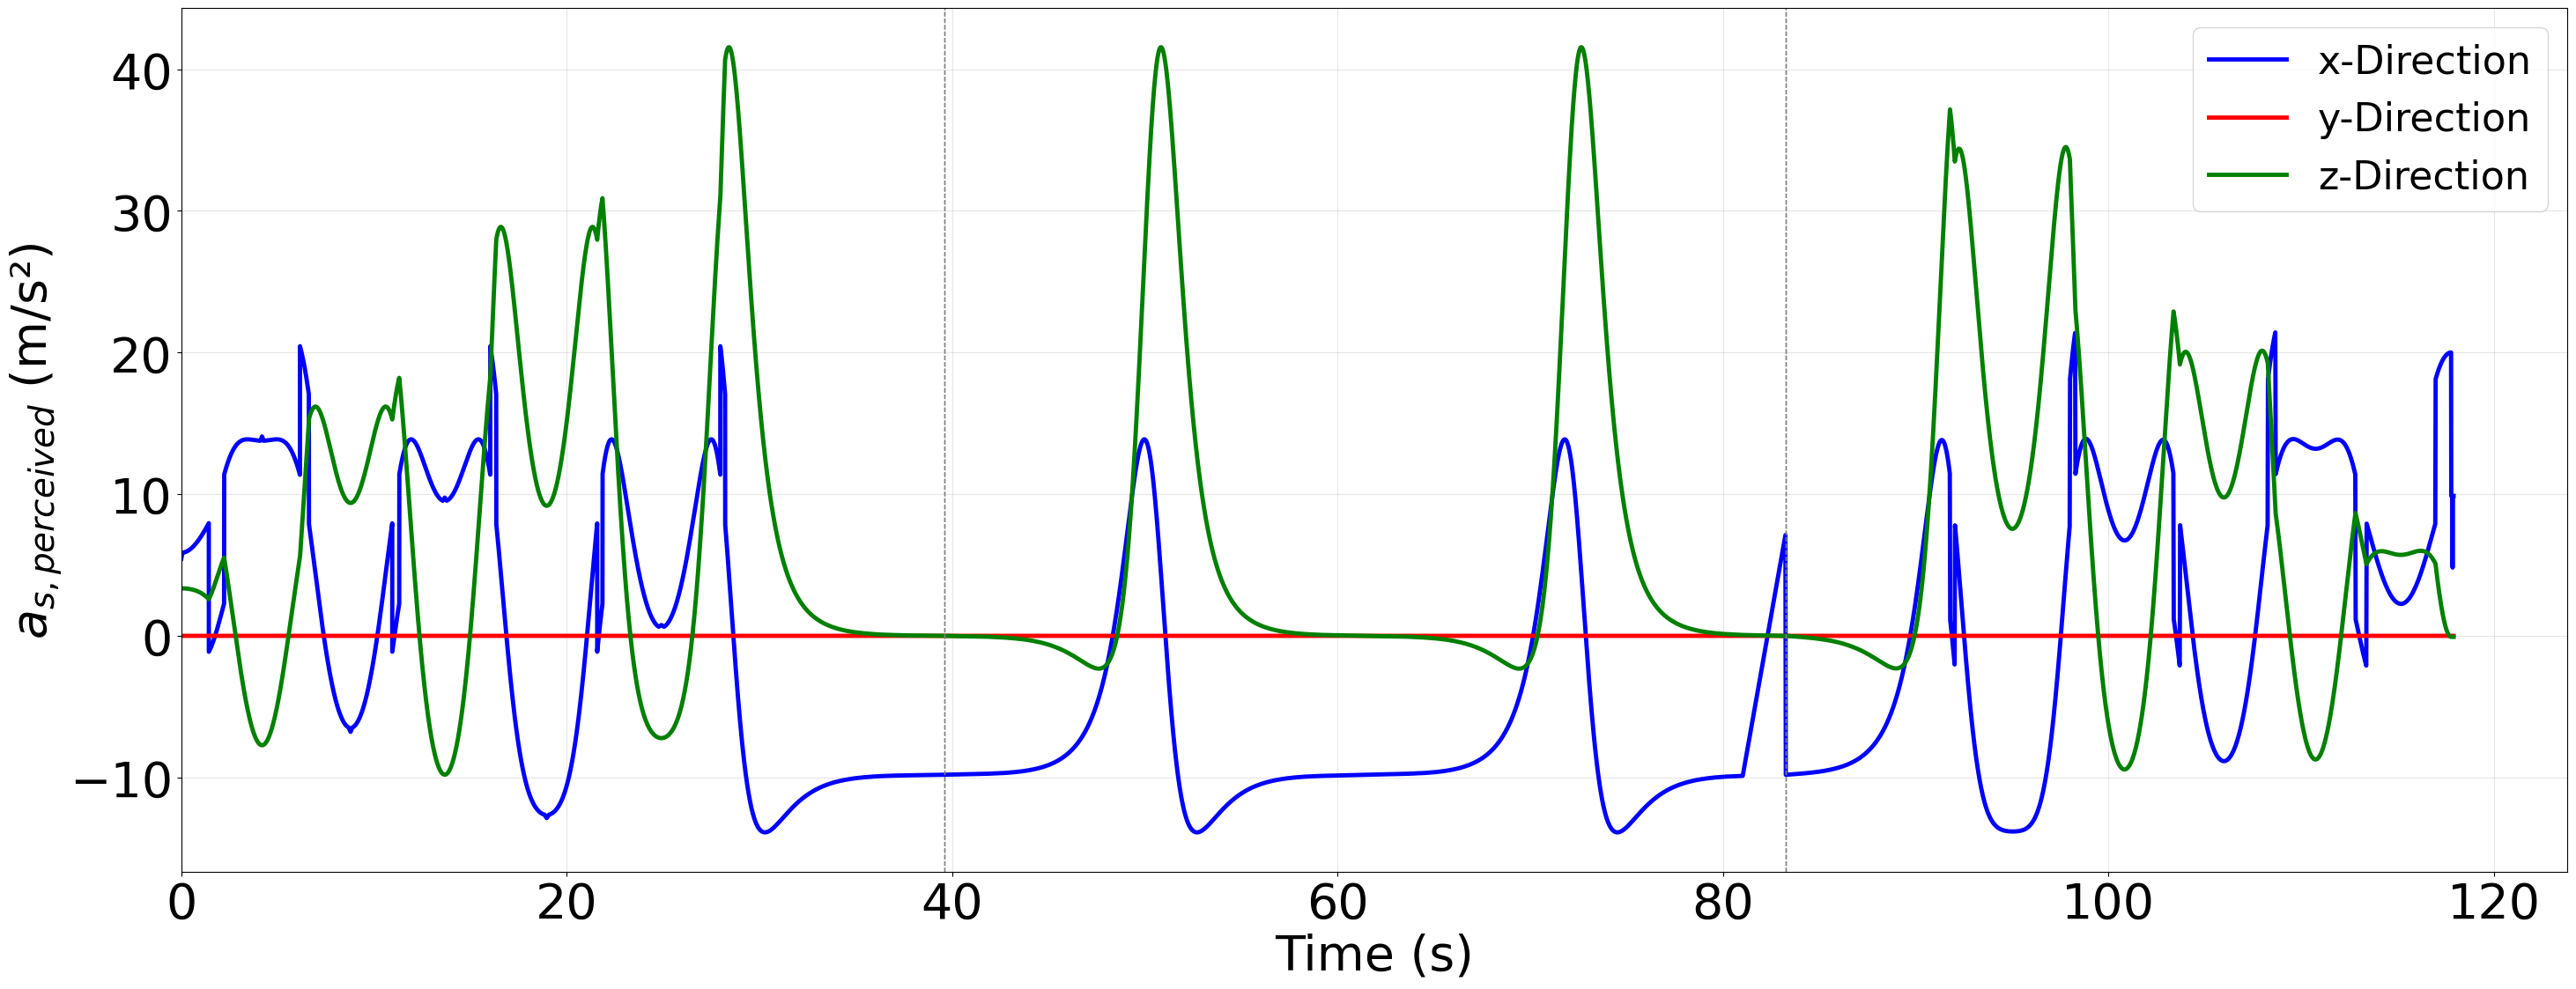

In [48]:
fig2 = plt.figure(figsize=(30, 12))
plt.plot(time, acc_N_x, 'b-', linewidth=3.5, label='x-Direction')
plt.plot(time, acc_N_y, 'r-', linewidth=3.5, label='y-Direction')
plt.plot(time, acc_N_z, 'g-', linewidth=3.5, label='z-Direction')
plt.axvline(t1, color='grey', linestyle='--', linewidth=1.0)
plt.axvline(t2, color='grey', linestyle='--', linewidth=1.0)
plt.legend(loc='upper right')
plt.ylabel(r'$a_{s, perceived}$ (m/s²)')
plt.grid(True, alpha=0.3)
plt.xlim(time[0], None)
plt.axvline(t1, color='grey', linestyle='--', linewidth=1.0)
plt.axvline(t2, color='grey', linestyle='--', linewidth=1.0)
plt.xlabel('Time (s)')
plt.tight_layout()
plt.savefig('doc/RiderAccelerationsNon-RotatingFrame.png')
plt.show()

In [49]:
state_dict_s = process_self_rotate_data(json_file_path, omega_self_0=0.4)

sorted_keys = sorted(state_dict_s.keys(), key=int)
n_states = len(sorted_keys)

time_sr = np.array([state_dict_s[k]['time'] for k in sorted_keys])
theta_sr = np.array([state_dict_s[k]['theta'] for k in sorted_keys])
omega_sr = np.array([state_dict_s[k]['omega'] for k in sorted_keys])
velocity_sr = np.array([state_dict_s[k]['velocity'] for k in sorted_keys])
dvdt_sr = np.array([state_dict_s[k]['acc_pv'] for k in sorted_keys])
a_centi_p_sr = omega**2 * L

# Passenger coordinate accelerations
theta_s_sr = np.array([state_dict_s[k]['theta_s'] for k in sorted_keys])
acc_N_x_sr = np.array([state_dict_s[k]['acc_N_x'] for k in sorted_keys])
acc_N_y_sr = np.array([state_dict_s[k]['acc_N_y'] for k in sorted_keys])
acc_N_z_sr = np.array([state_dict_s[k]['acc_N_z'] for k in sorted_keys])

# Additional quantities
jerk_sr = np.array([state_dict_s[k]['jerk'] for k in sorted_keys])
coriolis_sr = np.array([state_dict_s[k]['coriolis'] for k in sorted_keys])

t1, f1 = 39.609093, 817684.72
t2, f2 = 83.234, 911223.0


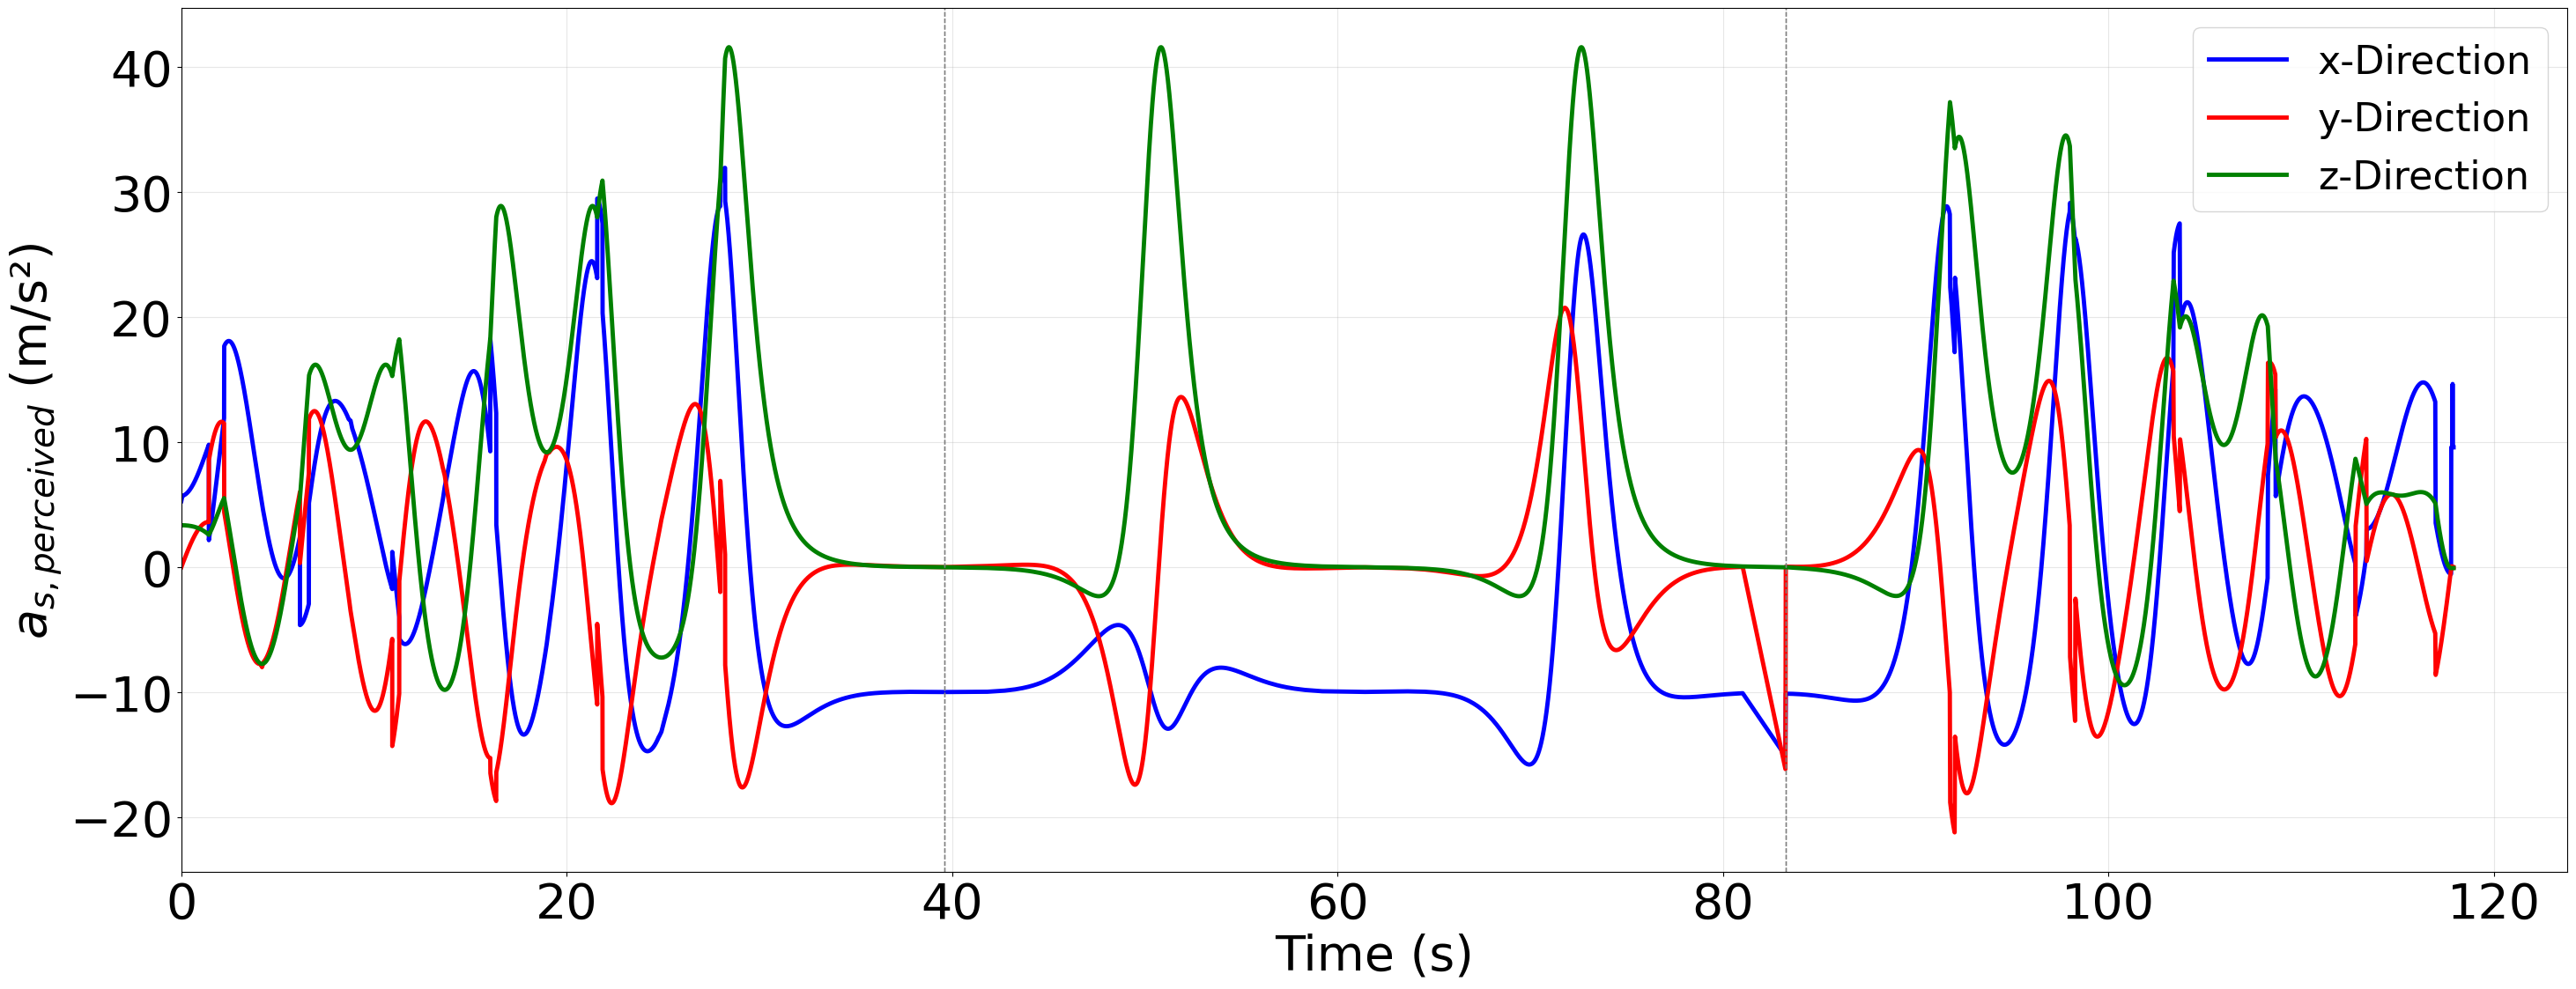

In [50]:
# Plt passenger accelerations
fig = plt.figure(figsize=(30, 12))


plt.plot(time_sr, acc_N_x_sr, 'b-', linewidth=3.5, label='x-Direction')
plt.plot(time_sr, acc_N_y_sr, 'r-', linewidth=3.5, label='y-Direction')
plt.plot(time_sr, acc_N_z_sr, 'g-', linewidth=3.5, label='z-Direction')
plt.axvline(t1, color='grey', linestyle='--', linewidth=1.0)
plt.axvline(t2, color='grey', linestyle='--', linewidth=1.0)
# 右上角
plt.legend(loc='upper right')
plt.ylabel(r'$a_{s, perceived}$ (m/s²)')
plt.grid(True, alpha=0.3)
plt.xlim(time_sr[0], None)
plt.axvline(t1, color='grey', linestyle='--', linewidth=1.0)
plt.axvline(t2, color='grey', linestyle='--', linewidth=1.0)
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('doc/RiderAccelerationsSelf-RotatingFrame.png')
plt.show()

================== Excitement Value Statistics with SelfRotate=================
Max Excitement Value: 4.488
Min Excitement Value: 0.364
Total Excitement Value (Integral): 165.770
Average Excitement Value: 1.406
Average Total Acceleration: 33.229 m/s²
Max Total Acceleration: 85.712 m/s²
Average Scale Height: 21.648 m
Max Scale Height: 36.000 m
Average Jerk: 10.643 m/s³
Max Jerk: 24.910 m/s³


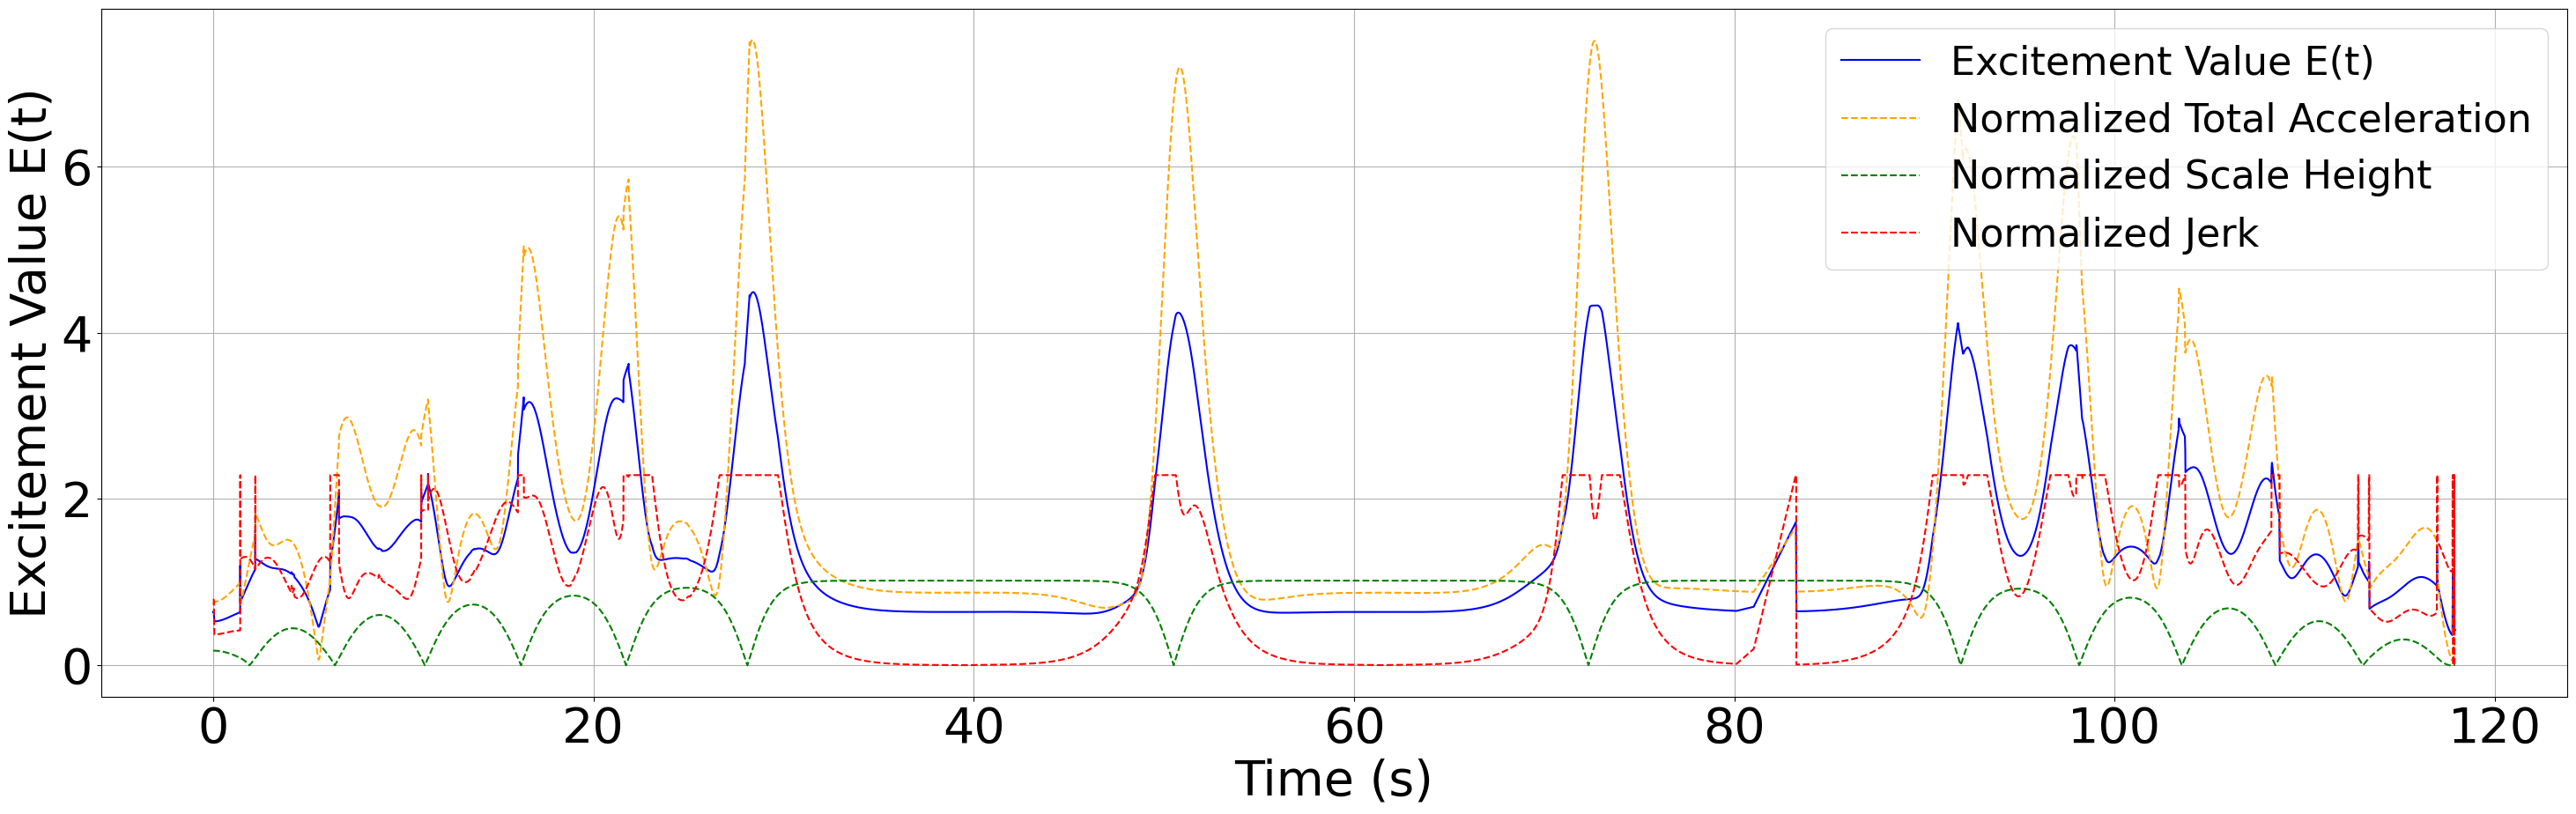

In [51]:
def excitement_value(a_total, scale_h, jerk):
    """
    Calculate excitement value E(t) = a_total(t) * scale_h(t)
    """
    ExV = 0.5 * a_total / 11.4 + 0.3 * jerk / 10.89 + 0.2 * scale_h / 5.89
    return ExV

a_total_sr = calculate_total_acceleration(acc_N_x_sr, acc_N_y_sr, acc_N_z_sr)
height_sr = L * (1 - np.cos(theta_sr))
scale_h_sr = (height_sr) ** 0.5
dadt_value_sr = dadt(acc_N_x_sr, acc_N_y_sr, acc_N_z_sr, time_sr)
ExV_sr = excitement_value(a_total_sr, scale_h_sr, dadt_value_sr)
min_index = np.argmin(ExV_sr)

print("================== Excitement Value Statistics with SelfRotate=================")
min_index = np.argmin(ExV_sr)
print(f"Max Excitement Value: {np.max(ExV_sr):.3f}")
print(f"Min Excitement Value: {np.min(ExV_sr):.3f}")
total_ExV_sr = np.trapezoid(ExV_sr, time_sr)
print(f"Total Excitement Value (Integral): {total_ExV_sr:.3f}")
print(f"Average Excitement Value: {total_ExV_sr/time_sr[-1]:.3f}")


print(f"Average Total Acceleration: {np.mean(a_total_sr):.3f} m/s²")
print(f"Max Total Acceleration: {np.max(a_total_sr):.3f} m/s²")
print(f"Average Scale Height: {np.trapezoid(height_sr, time_sr)/time_sr[-1]:.3f} m")
print(f"Max Scale Height: {np.max(height_sr):.3f} m")
print(f"Average Jerk: {np.trapezoid(dadt_value_sr, time_sr)/time_sr[-1]:.3f} m/s³")
print(f"Max Jerk: {np.max(dadt_value_sr):.3f} m/s³")

plt.figure(figsize=(30, 10))
plt.plot(time_sr, ExV_sr, label='Excitement Value E(t)', color='blue')
plt.plot(time_sr, a_total_sr / 11.4, label='Normalized Total Acceleration', color='orange', linestyle='--')
plt.plot(time_sr, scale_h_sr / 5.89, label='Normalized Scale Height', color='green', linestyle='--')
plt.plot(time_sr, dadt_value_sr / 10.89, label='Normalized Jerk', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Excitement Value E(t)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('doc/ExF-R.png')
plt.show()

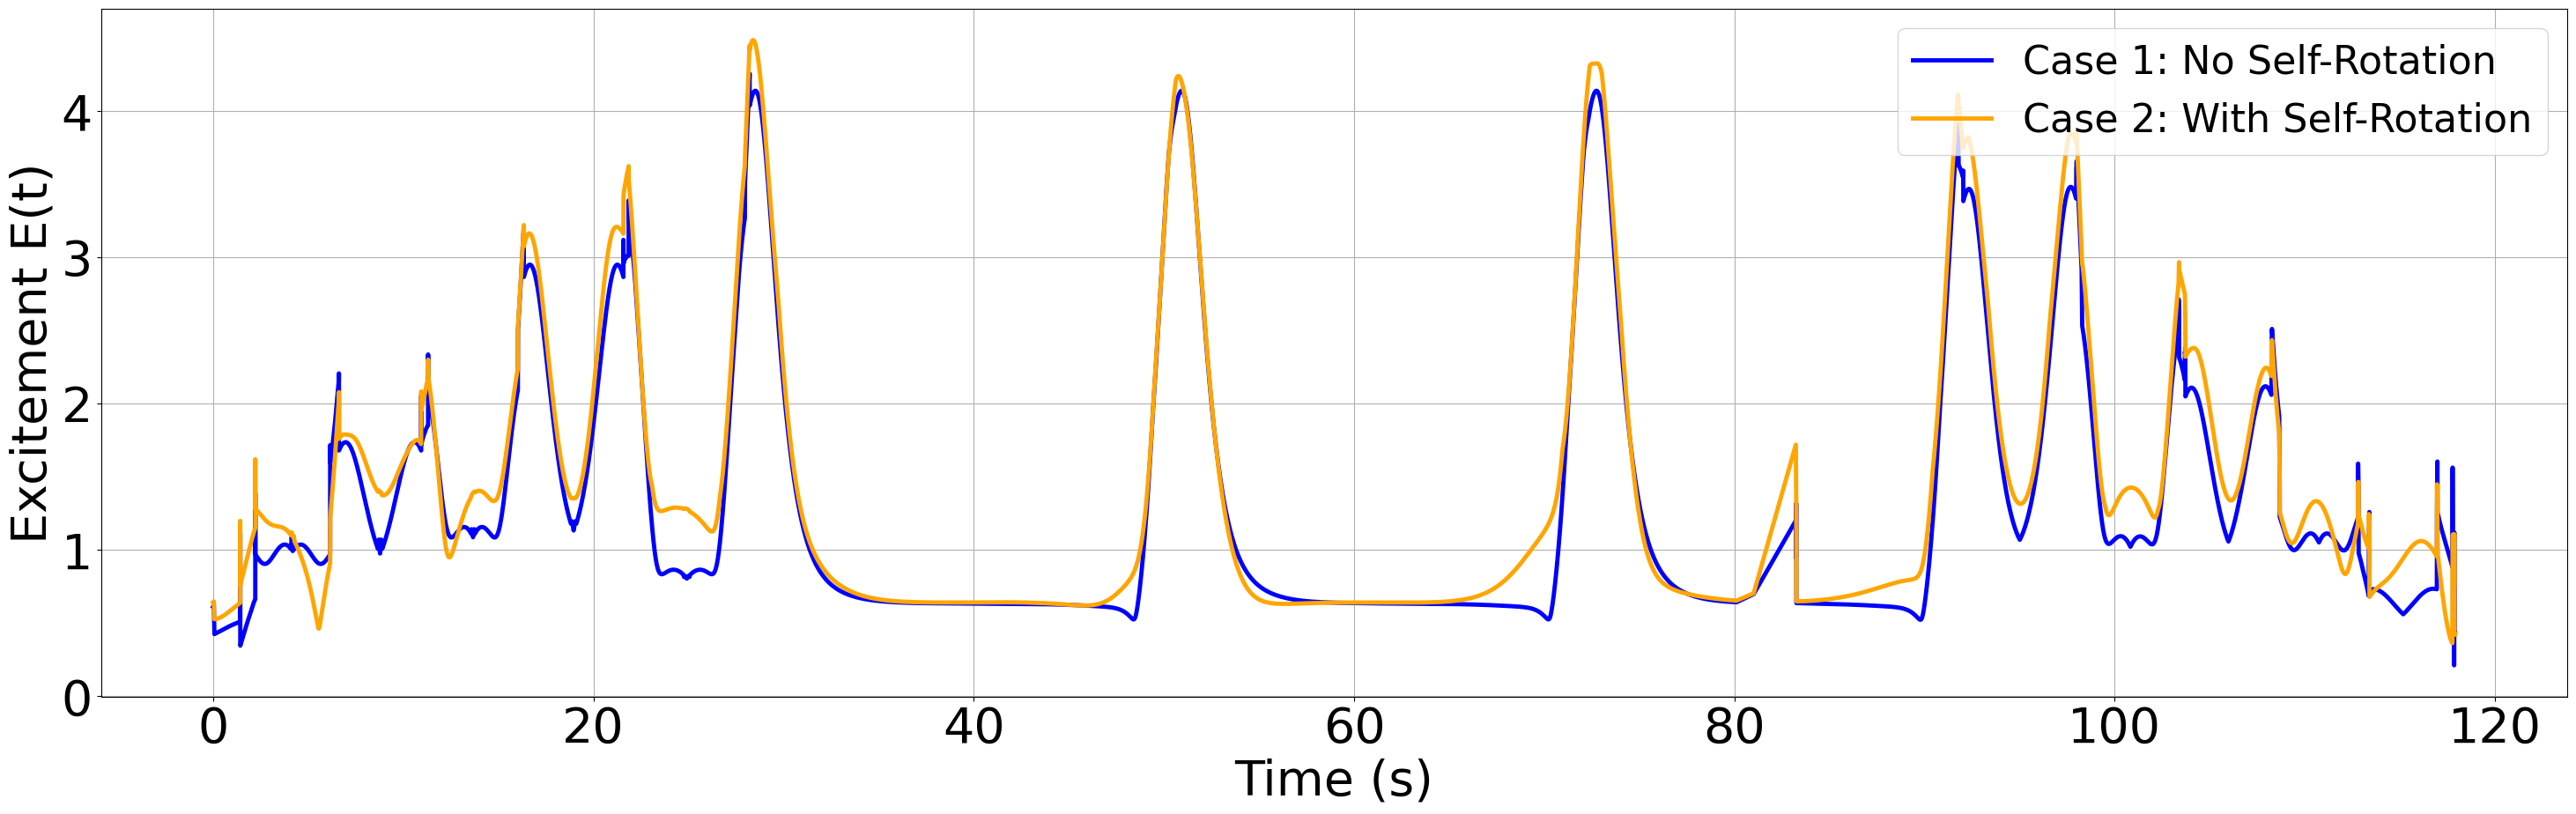

In [52]:
plt.figure(figsize=(30, 10))
plt.plot(time_sr, ExV, label='Case 1: No Self-Rotation', color='blue', linewidth=3.5)
plt.plot(time_sr, ExV_sr, label='Case 2: With Self-Rotation', color='orange', linewidth=3.5)
plt.xlabel('Time (s)')
plt.ylabel('Excitement E(t)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('doc/ExcitementFunctionCompare.png')
plt.show()